In [1]:
import numpy as np

def make_SE3(R, p):
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = np.asarray(p,float)
    return T


R_home = np.array([
    [0.0, 0.0, 1.0],
    [0.0,-1.0, 0.0],
    [1.0, 0.0, 0.0]
],float)

L2 = 0.5
H_VIS = 0.5

p_home = np.array([L2,0.0,0.0])
M = make_SE3(R_home,p_home)

In [2]:
# 4 wi, 4 qi, unified screw build (J4 uses linear term)
w1 = np.array([0, 0, 1.0])
w2 = np.array([0,-1.0, 0])
w3 = np.array([0,-1.0, 0])
w4 = np.zeros(3)

q1 = np.zeros(3)
q2 = np.zeros(3)
q3 = np.array([L2, 0, 0])
q4 = np.zeros(3)

vlin4 = np.array([1.0, 0, 0], float)
vlin4 /= np.linalg.norm(vlin4)

W    = np.vstack([w1, w2, w3, w4])
Q    = np.vstack([q1, q2, q3, q4])
VLIN = np.vstack([np.zeros(3), np.zeros(3), np.zeros(3), vlin4])

V = -np.cross(W, Q) + VLIN
Slist = np.hstack([W, V])

print("Constants:")
print("  L2 =", L2, "m")

print("\nHome EE pose M = [R|p]:")
print(M)
print("\nR_home (rows):\n", R_home)
print("\np_home:", p_home)

print("\nSlist (rows J1..J4):\n", Slist)

Constants:
  L2 = 0.5 m

Home EE pose M = [R|p]:
[[ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]]

R_home (rows):
 [[ 0.  0.  1.]
 [ 0. -1.  0.]
 [ 1.  0.  0.]]

p_home: [0.5 0.  0. ]

Slist (rows J1..J4):
 [[ 0.   0.   1.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   1.   0.   0. ]]


In [3]:
def screw_hat(S):
    wx, wy, wz, vx, vy, vz = S
    return np.array([[0, -wz,  wy, vx],
                     [wz,   0, -wx, vy],
                     [-wy, wx,   0, vz],
                     [0,    0,   0,  0]], float)

print("Hat matrices [S]^ (4x4) for each joint:")
for i, S in enumerate(Slist, 1):
    print(f"J{i}:\n{screw_hat(S)}\n")

Hat matrices [S]^ (4x4) for each joint:
J1:
[[ 0. -1.  0.  0.]
 [ 1.  0. -0.  0.]
 [-0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

J2:
[[ 0. -0. -1.  0.]
 [ 0.  0. -0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

J3:
[[ 0.  -0.  -1.   0. ]
 [ 0.   0.  -0.   0. ]
 [ 1.   0.   0.  -0.5]
 [ 0.   0.   0.   0. ]]

J4:
[[ 0. -0.  0.  1.]
 [ 0.  0. -0.  0.]
 [-0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]



In [4]:
from math import sin, cos
import numpy as np

def exp_se3_hat(Xi_hat, theta):
    """
    Exponential map for a screw axis.
    Xi_hat: 4x4 matrix [ [w]_x  v; 0 0 ]
    theta: joint variable (rad for revolute, m for prismatic)
    """
    w = np.array([Xi_hat[2,1], Xi_hat[0,2], Xi_hat[1,0]])
    v = Xi_hat[:3,3]
    wn = np.linalg.norm(w)

    if wn < 1e-12:  # prismatic
        T = np.eye(4)
        T[:3,3] = v * theta
        return T

    w = w / wn
    wx, wy, wz = w
    wx_hat = np.array([[0, -wz,  wy],
                       [wz,   0, -wx],
                       [-wy, wx,  0]])
    wx2 = wx_hat @ wx_hat

    ct, st = cos(theta), sin(theta)
    R = np.eye(3) + st*wx_hat + (1-ct)*wx2
    V = np.eye(3)*theta + (1-ct)*wx_hat + (theta-st)*wx2
    p = V @ v

    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = p
    return T

def poe_fk_from_hats(Slist, thetas, M):
    """Product of exponentials FK: T(θ) = (∏ exp([Si]^ θi)) M"""
    T = np.eye(4)
    for S, th in zip(Slist, thetas):
        T = T @ exp_se3_hat(screw_hat(S), th)
    return T @ M

In [5]:
# Home position
theta_home = np.array([0.0, 0.0, 0.0, 0.0])   # [θ1, θ2, θ3, d4]

# User input
theta_test = np.array([0.4, -0.2, 0.3, 0.15])

T_home = poe_fk_from_hats(Slist, theta_home, M)
T_test = poe_fk_from_hats(Slist, theta_test, M)

print("T(home):\n", T_home)
print("T(test):\n", T_test)
print("EE position (test):", T_test[:3,3])

T(home):
 [[ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]]
T(test):
 [[-0.09195267  0.38941834  0.91645953  0.58881948]
 [-0.03887696 -0.92106099  0.38747287  0.24894888]
 [ 0.99500417  0.          0.09983342 -0.08435965]
 [ 0.          0.          0.          1.        ]]
EE position (test): [ 0.58881948  0.24894888 -0.08435965]


In [6]:
# === PoE FK using hat matrices (closed-form exp on se(3)) ===
from math import sin, cos

def exp_se3_hat(Xi_hat, theta):
    """
    Exponential of se(3) element (4x4) times scalar theta, returned as a 4x4 in SE(3).
    Xi_hat is [[[w]x, v],
               [ 0 ,  0]]
    We detect w from the 3x3 block and apply closed-form.
    """
    # Extract w and v from Xi_hat (no skew helper)
    Wx = Xi_hat[0,1]; Wy = Xi_hat[2,0]; Wz = Xi_hat[1,2]  # these are NOT w components; careful!
    # It's safer to reconstruct w from the anti-symmetric part:
    W = Xi_hat[:3,:3]
    w = np.array([W[2,1], W[0,2], W[1,0]], float)  # because [w]_x = [[0,-wz, wy],[wz,0,-wx],[-wy,wx,0]]
    v = Xi_hat[:3,3]

    wn = np.linalg.norm(w)
    T = np.eye(4)

    if wn < 1e-12:
        # Pure translation
        T[:3,:3] = np.eye(3)
        T[:3, 3] = v * theta
        return T

    # Normalize axis
    w = w / wn
    wx, wy, wz = w

    # Build [w]_x and [w]_x^2 explicitly (no skew())
    wx_hat = np.array([
        [    0, -wz,  wy],
        [   wz,   0, -wx],
        [  -wy,  wx,   0]
    ], float)
    wx2 = wx_hat @ wx_hat

    # Rodrigues for R
    ct, st = cos(wn*theta), sin(wn*theta)   # but wn is 1 after normalization
    R = np.eye(3) + st*wx_hat + (1-ct)*wx2

    # V(theta) for the translational part: p = V v
    Vtheta = (np.eye(3)*theta
              + (1-ct)*wx_hat
              + (wn*theta - st)/wn * wx2)   # wn=1, but keep formula general

    p = Vtheta @ v

    T[:3,:3] = R
    T[:3, 3] = p
    return T

def poe_fk_from_hats(Slist, thetas, M):
    """T = (∏_i exp([S_i]^ θ_i)) M, using 4x4 hat matrices and exp_se3_hat."""
    T = np.eye(4)
    for S, th in zip(Slist, thetas):
        Xi_hat = screw_hat(S)
        T = T @ exp_se3_hat(Xi_hat, th)
    return T @ M

# ---- Try it: home and a sample configuration ----
theta_home = np.array([0.0, 0.0, 0.0, 0.0])         # [θ1, θ2, θ3, d4]
theta_test = np.array([0.4, -0.2, 0.3, 0.15])       # example (radians, meters)

T_home = poe_fk_from_hats(Slist, theta_home, M)
T_test = poe_fk_from_hats(Slist, theta_test, M)

print("\nT(home):\n", T_home)
print("\nT(test):\n", T_test)
print("\nEE position (test) [m]:", T_test[:3,3])


T(home):
 [[ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]]

T(test):
 [[-0.09195267  0.38941834  0.91645953  0.58881948]
 [-0.03887696 -0.92106099  0.38747287  0.24894888]
 [ 0.99500417  0.          0.09983342 -0.08435965]
 [ 0.          0.          0.          1.        ]]

EE position (test) [m]: [ 0.58881948  0.24894888 -0.08435965]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def keypoints(theta, L2, M, z_lift=0.0):
    """Return 3×3: [Base, Elbow(J3), EE]."""
    T12 = np.eye(4)
    for k in range(2):  # J1,J2
        T12 = T12 @ exp_se3_hat(screw_hat(Slist[k]), theta[k])
    elbow = (T12 @ np.array([L2, 0, 0, 1.0]))[:3]

    T = np.eye(4)
    for k in range(len(Slist)):  # full PoE
        T = T @ exp_se3_hat(screw_hat(Slist[k]), theta[k])
    ee = (T @ M)[:3, 3]

    P = np.vstack([np.zeros(3), elbow, ee])
    if z_lift: P[:,2] += z_lift
    return P

def plot_initial_final(theta_init, theta_final, L2, M, z_lift=0.0,
                       title="Initial (dashed) vs Final (solid) — links view"):
    P0 = keypoints(theta_init,  L2, M, z_lift)
    Pf = keypoints(theta_final, L2, M, z_lift)

    colors = ["tab:green", "tab:purple"]  # L2, slider
    stroke = [pe.withStroke(linewidth=3, foreground="white")]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(title)
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")

    all_pts = np.vstack([P0, Pf])
    mins, maxs = all_pts.min(axis=0), all_pts.max(axis=0)
    ctr = (mins + maxs) / 2.0
    span = max(0.5, float(np.max(maxs - mins)))
    lim  = span / 1.8
    ax.set(xlim=(ctr[0]-lim, ctr[0]+lim),
           ylim=(ctr[1]-lim, ctr[1]+lim),
           zlim=(ctr[2]-lim, ctr[2]+lim))

    # segments: Base->Elbow (L2), Elbow->EE (slider)
    ax.plot(P0[0:2,0], P0[0:2,1], P0[0:2,2], ls="--", lw=2, color=colors[0], alpha=0.7)
    ax.plot(P0[1:3,0], P0[1:3,1], P0[1:3,2], ls="--", lw=2, color=colors[1], alpha=0.7)
    ax.plot(Pf[0:2,0], Pf[0:2,1], Pf[0:2,2], ls="-",  lw=3, color=colors[0], alpha=0.95)
    ax.plot(Pf[1:3,0], Pf[1:3,1], Pf[1:3,2], ls="-",  lw=3, color=colors[1], alpha=0.95)

    # markers
    ax.scatter(P0[0,0], P0[0,1], P0[0,2], marker="x", s=55, color="tab:orange", alpha=0.9)
    ax.scatter(Pf[0,0], Pf[0,1], Pf[0,2], marker="o", s=60, edgecolor="k", color="tab:orange")
    ax.scatter(P0[1,0], P0[1,1], P0[1,2], marker="x", s=55, color="tab:green",  alpha=0.9)
    ax.scatter(Pf[1,0], Pf[1,1], Pf[1,2], marker="o", s=60, edgecolor="k", color="tab:green")
    ax.scatter(P0[2,0], P0[2,1], P0[2,2], marker="^", s=80, color="gray",  alpha=0.9, label="EE (init)")
    ax.scatter(Pf[2,0], Pf[2,1], Pf[2,2], marker="^", s=90, edgecolor="k", color="black", alpha=0.95, label="EE (final)")

    # labels near final
    off = 0.03 * span
    ax.text(Pf[0,0], Pf[0,1], Pf[0,2]+off, "Base", fontsize=10, path_effects=stroke)
    ax.text(Pf[1,0]+off, Pf[1,1]+off, Pf[1,2]+off, "Elbow (J3)", color="tab:green",
            fontsize=10, weight="bold", path_effects=stroke)
    ax.text(Pf[2,0]+off, Pf[2,1], Pf[2,2]+off, "EE", fontsize=10, path_effects=stroke)

    # link labels (final)
    mid_L2 = 0.5*(Pf[0] + Pf[1])
    mid_S  = 0.5*(Pf[1] + Pf[2])
    ax.text(mid_L2[0], mid_L2[1], mid_L2[2]+off, "L2",       color=colors[0], fontsize=10, path_effects=stroke)
    ax.text(mid_S[0],  mid_S[1],  mid_S[2]+off,  "Prismatic",   color=colors[1], fontsize=10, path_effects=stroke)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

T(final):
 [[-0.58625848  0.71735609  0.37643224  0.36279488]
 [-0.60363434 -0.69670671  0.38758915  0.3735476 ]
 [ 0.54030231  0.          0.84147098  0.45061543]
 [ 0.          0.          0.          1.        ]]
EE (final): [0.36279488 0.3735476  0.45061543]


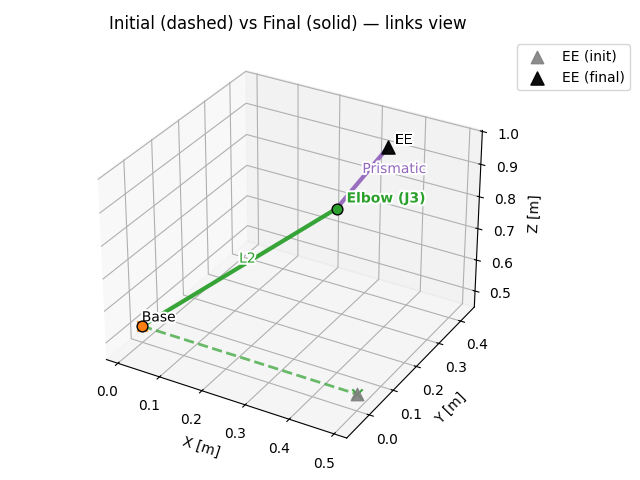

In [8]:
# Quick test: pick configs and draw
theta_init  = np.array([0.0, 0.0, 0.0, 0.00])   # [θ1, θ2, θ3, d4]
theta_final = np.array([0.8, 0.6, 0.4, 0.20])

%matplotlib widget

# Show numeric pose too
T_final = poe_fk_from_hats(Slist, theta_final, M)
print("T(final):\n", T_final)
print("EE (final):", T_final[:3,3])

# Plot initial vs final (Base → L2 → Slider → EE)
plot_initial_final(theta_init, theta_final, L2=L2, M=M, z_lift=H_VIS,
                   title="Initial (dashed) vs Final (solid) — links view")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _blend(t, T):
    tau = np.clip(t/T, 0.0, 1.0)
    return 3*tau**2 - 2*tau**3

def animate_links(theta0, theta1, L2, M, z_lift=0.0,
                  T=4.0, fps=30, filename="arm_transition.mp4"):
    ts = np.linspace(0, T, int(T*fps)+1)
    traj = np.array([theta0 + _blend(t, T)*(theta1-theta0) for t in ts])

    P0 = keypoints(theta0, L2, M, z_lift)
    P1 = keypoints(theta1, L2, M, z_lift)
    all_pts = np.vstack([P0, P1])
    mins, maxs = all_pts.min(axis=0), all_pts.max(axis=0)
    ctr = (mins + maxs)/2.0
    span = max(0.5, float(np.max(maxs - mins)))
    lim  = span/1.8

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]",
           xlim=(ctr[0]-lim, ctr[0]+lim),
           ylim=(ctr[1]-lim, ctr[1]+lim),
           zlim=(ctr[2]-lim, ctr[2]+lim))
    ax.set_title("Links animation")

    (seg_L2,) = ax.plot([], [], [], lw=3, color="tab:green")
    (seg_S ,) = ax.plot([], [], [], lw=3, color="tab:purple")
    base = ax.scatter([], [], [], marker="o", s=60, edgecolor="k", color="tab:orange")
    elbow= ax.scatter([], [], [], marker="o", s=60, edgecolor="k", color="tab:green")
    ee   = ax.scatter([], [], [], marker="^", s=90, edgecolor="k", color="black")

    def update(k):
        P = keypoints(traj[k], L2, M, z_lift)  # rows: [Base, Elbow, EE]
        seg_L2.set_data(P[0:2,0], P[0:2,1]); seg_L2.set_3d_properties(P[0:2,2])
        seg_S .set_data(P[1:3,0], P[1:3,1]); seg_S .set_3d_properties(P[1:3,2])
        base._offsets3d  = (np.r_[P[0,0]], np.r_[P[0,1]], np.r_[P[0,2]])
        elbow._offsets3d = (np.r_[P[1,0]], np.r_[P[1,1]], np.r_[P[1,2]])
        ee._offsets3d    = (np.r_[P[2,0]], np.r_[P[2,1]], np.r_[P[2,2]])
        return seg_L2, seg_S, base, elbow, ee

    frames = len(ts)
    if animation.writers.is_available("ffmpeg"):
        writer = animation.FFMpegWriter(fps=fps, bitrate=1800)
        with writer.saving(fig, filename, dpi=120):
            for k in range(frames):
                update(k); writer.grab_frame()
    else:
        from matplotlib.animation import PillowWriter
        gif = filename.replace(".mp4", ".gif")
        writer = PillowWriter(fps=fps)
        with writer.saving(fig, gif, dpi=120):
            for k in range(frames):
                update(k); writer.grab_frame()
        filename = gif

    plt.close(fig)
    return filename

In [10]:
theta_init  = np.array([0.0, 0.0, 0.0, 0.00])
theta_final = np.array([0.8, 0.6, 0.4, 0.20])
out = animate_links(theta_init, theta_final, L2=L2, M=M, z_lift=H_VIS, T=4.0, fps=30)
print("Saved:", out)

Saved: arm_transition.mp4
